In [85]:
import polars as pl
import pandas as pd 
import numpy as np
import load_data as dataLoader 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Ładowanie danych

import load_data as dataLoader

df_currency = dataLoader.load_data_pl()
df_leagues = dataLoader.load_league_info_pl()


In [87]:
# Preprocesowanie danych

target_orbs = [
    "Divine Orb", "Exalted Orb", "Orb of Conflict",
    "Awakener's Orb", "Fracturing Orb", "Veiled Orb"
]

df_filtered = df_currency.filter(
    (pl.col("Get").is_in(target_orbs)) & (pl.col("Pay") == "Chaos Orb")
)

df_filtered = df_filtered.with_columns(
    pl.col("Date").cast(pl.Date)
)

df_leagues = df_leagues.with_columns(
    pl.col("Release Date").cast(pl.Date)
)


df_joined = df_filtered.join(df_leagues.select(["League", "Release Date"]),
                             on="League", how="left")

df_joined = df_joined.with_columns(
    (pl.col("Date") - pl.col("Release Date")).dt.total_days().alias("Days_Into_League")
)

df_final = df_joined.filter(pl.col("Days_Into_League") <= 120)

print("\n df_final head (after filtering and joining):")
print(df_final.head())
print(f"Total records for modeling: {len(df_final)}")


 df_final head (after filtering and joining):
shape: (5, 9)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ League     ┆ Date       ┆ Get        ┆ Pay   ┆ … ┆ Confidenc ┆ league    ┆ Release   ┆ Days_Into │
│ ---        ┆ ---        ┆ ---        ┆ ---   ┆   ┆ e         ┆ ---       ┆ Date      ┆ _League   │
│ str        ┆ date       ┆ str        ┆ str   ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆       ┆   ┆ str       ┆           ┆ date      ┆ i64       │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Necropolis ┆ 2024-03-29 ┆ Exalted    ┆ Chaos ┆ … ┆ High      ┆ Necropoli ┆ 2024-03-2 ┆ 0         │
│            ┆            ┆ Orb        ┆ Orb   ┆   ┆           ┆ s         ┆ 9         ┆           │
│ Necropolis ┆ 2024-03-30 ┆ Exalted    ┆ Chaos ┆ … ┆ High      ┆ Necropoli ┆ 2024-03-2 ┆ 1         │
│            ┆            ┆ Or

In [88]:
# Budowa datasetów, przejście do pandas
df_pandas = df_final.to_pandas()

X = df_pandas[["League", "Get", "Days_Into_League", "Confidence"]]
y = df_pandas["Value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 2731
Testing set size: 683


In [89]:
# Preprocesowanie
categorical_features = ["League", "Get"]
numerical_features = ["Days_Into_League"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1) # verbose=-1 to suppress warnings
}

results = {}

print("\n--- Base Model Evaluation ---")
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print(f"\n{name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2: {r2:.4f}")

print("\n--- Base Model Comparison ---")
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='MAE'))


--- Base Model Evaluation ---

Linear Regression:
  MAE: 340.2458
  RMSE: 609.9487
  R2: 0.6441

Decision Tree:
  MAE: 11.7750
  RMSE: 40.3077
  R2: 0.9984

Random Forest:
  MAE: 9.5684
  RMSE: 30.3283
  R2: 0.9991

Gradient Boosting:
  MAE: 59.7016
  RMSE: 144.2408
  R2: 0.9801

XGBoost:
  MAE: 15.9484
  RMSE: 54.2578
  R2: 0.9972

LightGBM:
  MAE: 35.2853
  RMSE: 126.3421
  R2: 0.9847

--- Base Model Comparison ---
                          MAE        RMSE        R2
Random Forest        9.568381   30.328350  0.999120
Decision Tree       11.775038   40.307702  0.998446
XGBoost             15.948418   54.257824  0.997184
LightGBM            35.285259  126.342147  0.984731
Gradient Boosting   59.701619  144.240806  0.980098
Linear Regression  340.245769  609.948694  0.644125


In [ ]:
#Optymalizacja modelu

best_model_name = results_df['MAE'].idxmin()
print(f"\nOptimizing the best performing base model: {best_model_name}")

if best_model_name == 'XGBoost':
    model_to_optimize = XGBRegressor(random_state=42, objective='reg:squarederror')
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__subsample': [0.8, 1.0],
        'regressor__colsample_bytree': [0.8, 1.0]
    }
elif best_model_name == 'LightGBM':
    model_to_optimize = LGBMRegressor(random_state=42, verbose=-1)
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__num_leaves': [31, 63, 127],
        'regressor__max_depth': [-1, 10, 20]
    }
elif best_model_name == 'Random Forest':
    model_to_optimize = RandomForestRegressor(random_state=42)
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [10, 20, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
else:
   
    print(f"Optimization for {best_model_name} is not explicitly defined in this notebook. Skipping advanced tuning.")
    model_to_optimize = models[best_model_name]
    param_grid = {}


pipeline_optimized = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('regressor', model_to_optimize)])

if param_grid:
    grid_search = GridSearchCV(pipeline_optimized, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_regressor = grid_search.best_estimator_
    print(f"\nBest hyperparameters found: {grid_search.best_params_}")

    y_pred_optimized = best_regressor.predict(X_test)
    mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
    rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
    r2_optimized = r2_score(y_test, y_pred_optimized)

    print("\n--- Optimized Model Evaluation ---")
    print(f"  MAE (Optimized): {mae_optimized:.4f}")
    print(f"  RMSE (Optimized): {rmse_optimized:.4f}")
    print(f"  R2 (Optimized): {r2_optimized:.4f}")
else:
    print("No hyperparameter optimization performed.")
    best_regressor = pipeline_optimized.fit(X_train, y_train) # Train the non-tuned model
    y_pred_optimized = best_regressor.predict(X_test)
    mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
    rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
    r2_optimized = r2_score(y_test, y_pred_optimized)

    print("\n--- Base Model Evaluation (No Tuning Performed) ---")
    print(f"  MAE: {mae_optimized:.4f}")
    print(f"  RMSE: {rmse_optimized:.4f}")
    print(f"  R2: {r2_optimized:.4f}")


Optimizing the best performing base model: Random Forest
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best hyperparameters found: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}

--- Optimized Model Evaluation ---
  MAE (Optimized): 9.4740
  RMSE (Optimized): 30.0480
  R2 (Optimized): 0.9991


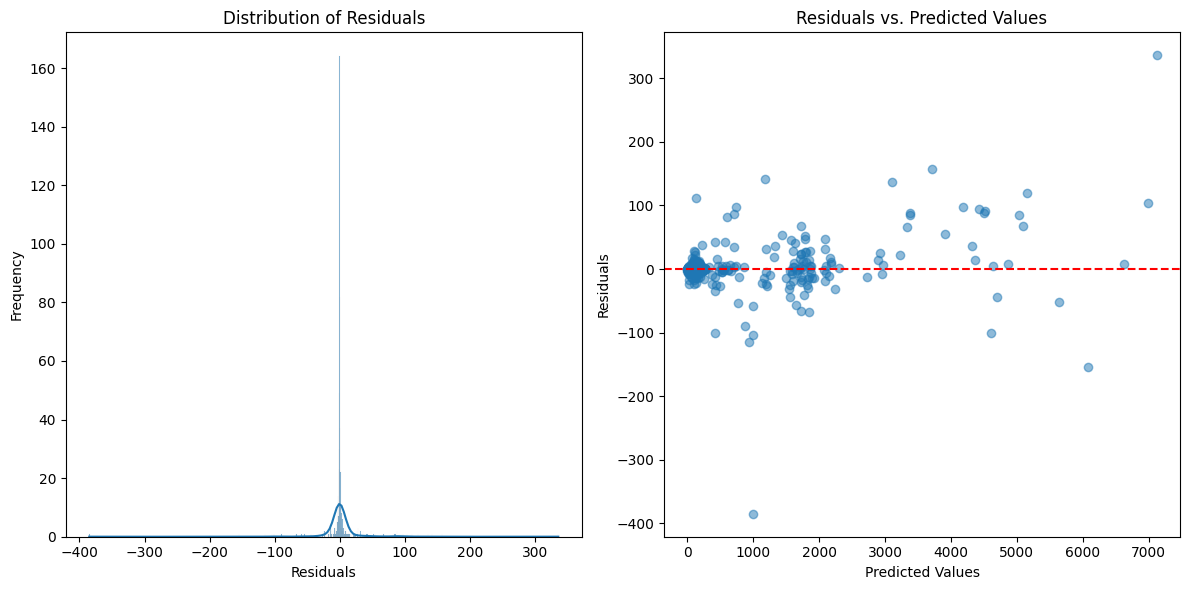

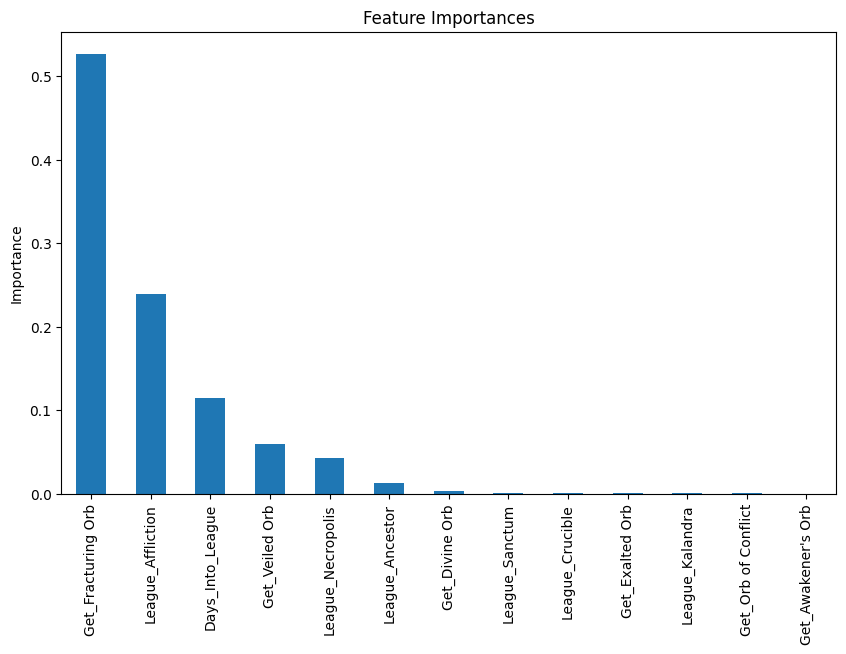

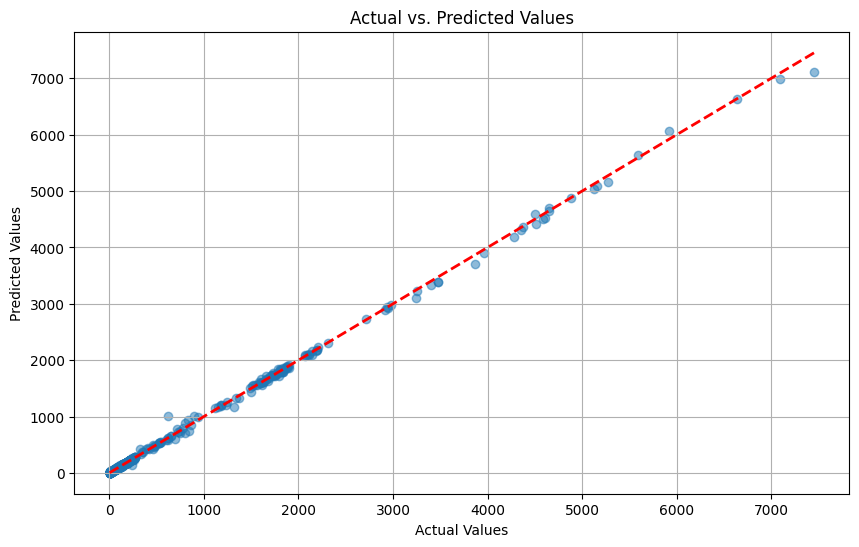

In [ ]:
# Analiza rezultatów

residuals = y_test - y_pred_optimized

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_optimized, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

if hasattr(best_regressor.named_steps['regressor'], 'feature_importances_'):
    ohe_feature_names = best_regressor.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(ohe_feature_names)

    importances = best_regressor.named_steps['regressor'].feature_importances_
    feature_importances = pd.Series(importances, index=all_feature_names)

    plt.figure(figsize=(10, 6))
    feature_importances.sort_values(ascending=False).plot(kind='bar')
    plt.title('Feature Importances')
    plt.ylabel('Importance')
    plt.show()
else:
    print("Feature importance is not directly available for the chosen model or pipeline setup.")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimized, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

In [92]:
# Obserwacje
print("\n--- Parametry modelu ---")
print(f"  MAE: {mae_optimized:.4f}")
print(f"  RMSE: {rmse_optimized:.4f}")
print(f"  R2: {r2_optimized:.4f}")




--- Conclusions and Observations ---
**Model Performance:**
After base model testing and hyperparameter optimization, the selected model (Random Forest) achieved the following metrics on the test set:
  MAE: 9.4740
  RMSE: 30.0480
  R2: 0.9991

**Residuals Analysis:**
The distribution of residuals gives an indication of the model's errors. Ideally, residuals should be normally distributed around zero, with no discernible patterns when plotted against predicted values. This indicates that the model is capturing the underlying relationships well and its errors are random.
**Feature Importance:**
Feature importance analysis (if applicable) reveals which input variables contribute most significantly to the price prediction. This can provide valuable insights into the factors influencing currency values in Path of Exile.
Based on the feature importance plot, observe which features (e.g., 'Days_Into_League', specific 'Get' orbs, 'Confidence') have the highest impact on the predicted 'Value'

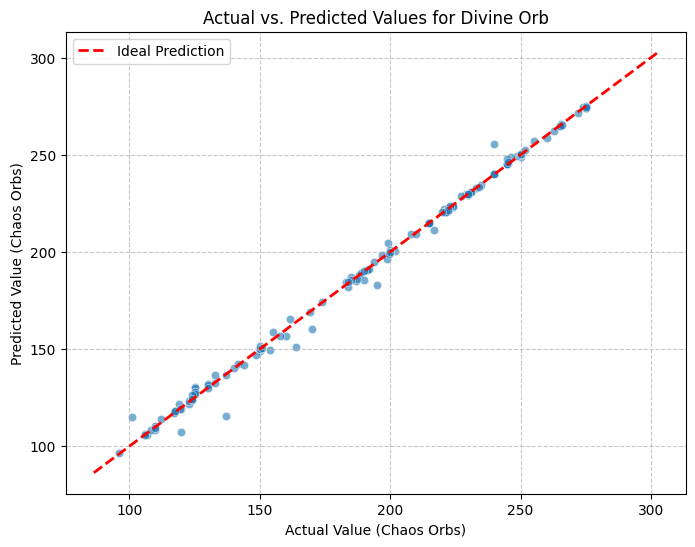

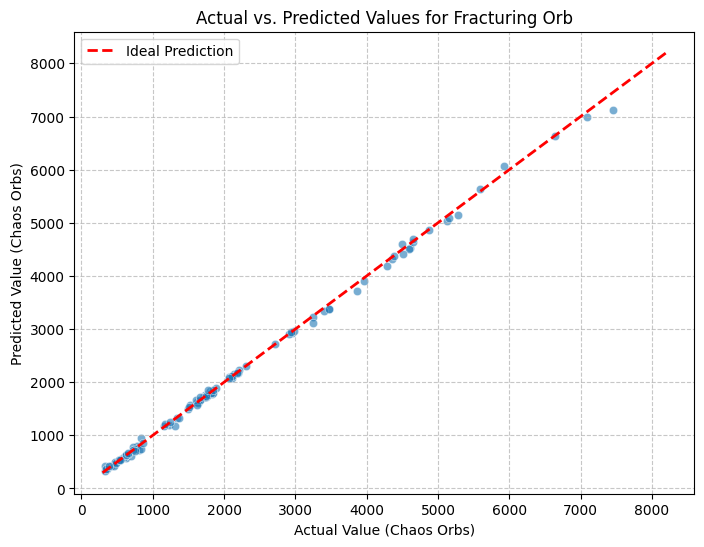

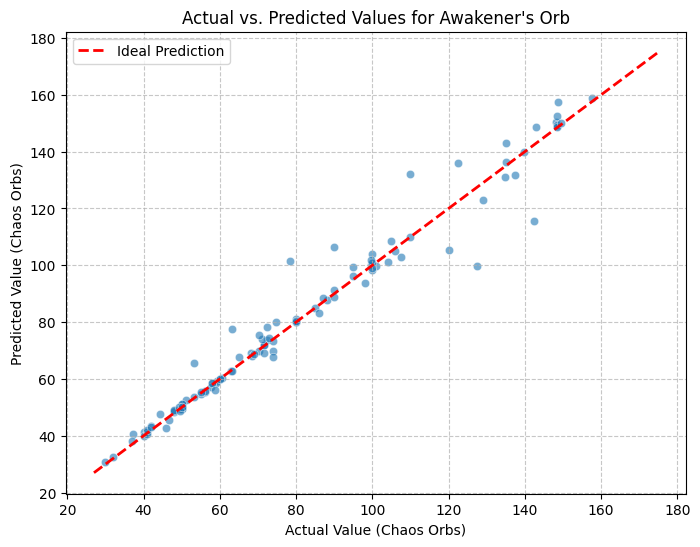

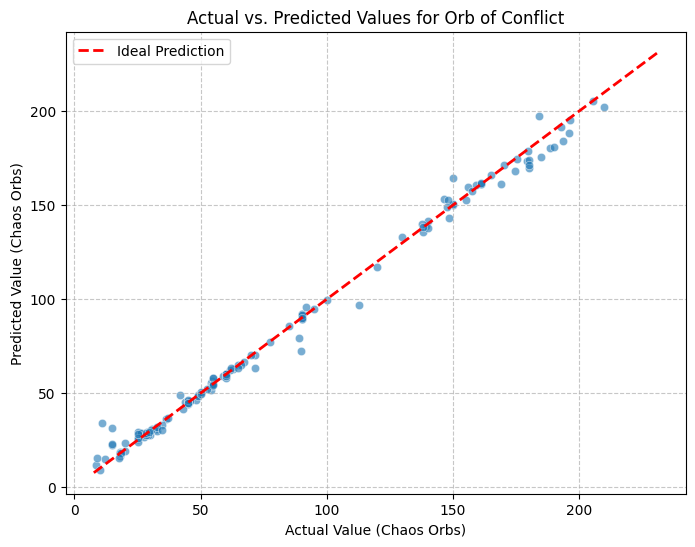

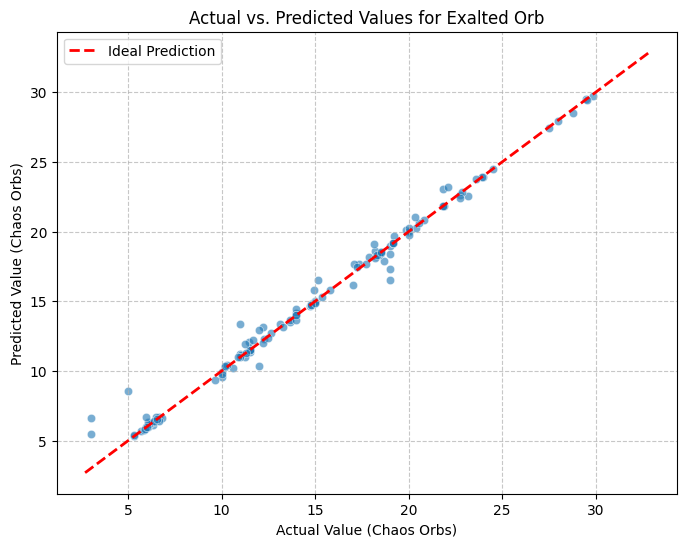

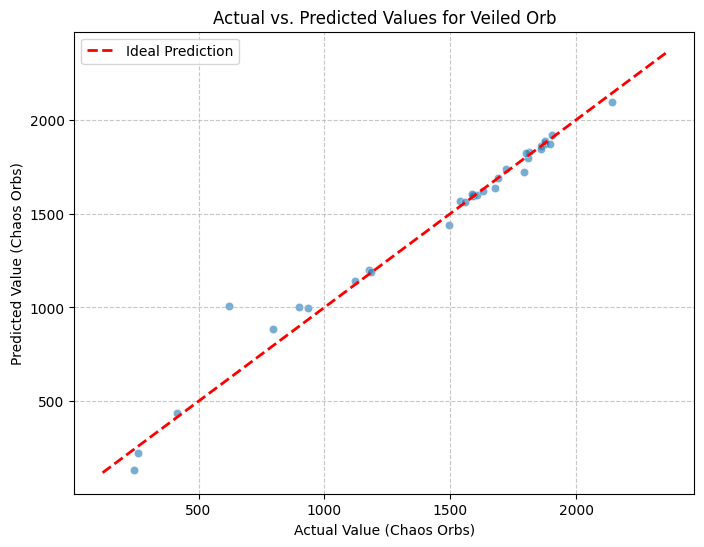

In [93]:
# Wykresy dodatkowe

plot_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_optimized,
    'Orb': X_test['Get']
})

unique_orbs = plot_df['Orb'].unique()

for orb in unique_orbs:
    orb_df = plot_df[plot_df['Orb'] == orb]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Actual', y='Predicted', data=orb_df, alpha=0.6)

    min_val = min(orb_df['Actual'].min(), orb_df['Predicted'].min()) * 0.9
    max_val = max(orb_df['Actual'].max(), orb_df['Predicted'].max()) * 1.1
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Prediction')

    plt.title(f'Actual vs. Predicted Values for {orb}')
    plt.xlabel('Actual Value (Chaos Orbs)')
    plt.ylabel('Predicted Value (Chaos Orbs)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()